# Monthly Readers Diversity Metrics #

In [2]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
    library(tidyverse); library(ggplot2); library(lubridate); library(scales); library(reshape2);
    library(wmf)
})


Pageviews data comes from wmf.pageview_hourly with IE corrections applied. Corrected data is stored in intermediate hive table mneisler.gs_pageviews_corrected with data stored back to September 2016. 

List of corrections and timespans that they are applied to:

* IEPKIRAF: since May 20, 2018
* IE7PKIRAF: January 1-May 19, 2018
* IE7PKIRAF & iOS mainpage: Sept 2016-Dec 31, 2017

## Interactions by Economic Region ##

### Update gs_pageviews_corrected table ###

In [ ]:
#Remember to update month to current metrics month and year
metrics_month = '07'
metrics_year = '2019'

In [ ]:
#update pageviews_corrected table with new month data.

gs_pageviews_query <- "
INSERT INTO TABLE mneisler.gs_pageviews_corrected
PARTITION (year, month, day)

SELECT date,
countries.economic_region AS region,
SUM(pageviews_country) AS pageviews,
year, month, day
FROM (
  SELECT 
  CONCAT(year,'-',LPAD(month,2,'0'),'-',LPAD(day,2,'0')) AS date,
  country_code,
  SUM(view_count) AS pageviews_country,
  year, month, day
  FROM wmf.pageview_hourly
  WHERE (year = '{metrics_year}'AND month = '{metrics_month}')
  AND agent_type='user'
  AND NOT (country_code IN ('PK', 'IR', 'AF') -- https://phabricator.wikimedia.org/T157404#3194046
  AND user_agent_map['browser_family'] = 'IE') -- https://phabricator.wikimedia.org/T193578#4300284
  GROUP BY year, month, day, country_code) AS bydatecountry
JOIN canonical_data.countries AS countries
ON bydatecountry.country_code = countries.iso_code
GROUP BY date, year, month, day, countries.economic_region;


In [ ]:
wmf::query_hive(gs_pageviews_query)

### Global South Pageviews ###

In [37]:
## Run pageview query and load data
query <- "
SELECT
date, region, pageviews
FROM mneisler.gs_pageviews_corrected
WHERE year >= 2017
"

In [38]:
pageviews_byregion <- wmf::query_hive(query)

In [39]:
pageviews_byregion$date <- as.Date(pageviews_byregion$date, format = "%Y-%m-%d")

In [40]:
gs_pageviews_monthly <- pageviews_byregion %>%
  mutate(date = floor_date(date, "month")) %>%
  filter(region == 'Global South') %>% #Look only at Global South
  group_by(date) %>%
  summarise(monthly_views = sum(as.numeric(pageviews))) %>%
  arrange(date) %>%
  mutate(yoy_percent = (monthly_views/lag(monthly_views,12) -1)*100)  %>%
  mutate(type = "pageviews")

tail(gs_pageviews_monthly)

date,monthly_views,yoy_percent,type
<date>,<dbl>,<dbl>,<chr>
2019-02-01,3578825856,6.1006531,pageviews
2019-03-01,3950836410,6.5692218,pageviews
2019-04-01,3721100969,3.1992450,pageviews
2019-05-01,3837559183,-0.8576066,pageviews
2019-06-01,3442174949,-3.7715663,pageviews
2019-07-01,3552435830,-3.0678349,pageviews


### Global South Seen Previews ###

In [9]:
# Collect previews from wmf.virtualpageview_hourly. Page previews was completed in April 2018.

previews_query <- "
SELECT date,
countries.economic_region AS region,
SUM(previews_seen_country) AS previews_seen
FROM (
  SELECT year, month, day, 
  CONCAT(year,'-',LPAD(month,2,'0'),'-',LPAD(day,2,'0')) AS date,
  country_code,
  SUM(view_count) AS previews_seen_country
  FROM wmf.virtualpageview_hourly 
  WHERE (year = 2018 AND month >=4) OR (year = 2019)
  GROUP BY year, month, day, country_code) AS bydatecountry
JOIN canonical_data.countries AS countries
ON bydatecountry.country_code = countries.iso_code
GROUP BY date, countries.economic_region
"

In [10]:
previews_byregion <- wmf::query_hive(previews_query)

In [11]:
previews_byregion$date <- as.Date(previews_byregion$date, format = "%Y-%m-%d")

In [12]:
gs_previews_monthly <- previews_byregion %>%
  mutate(date = floor_date(date, "month")) %>%
  filter(region == 'Global South') %>%  #Look only at Global South
  group_by(date) %>%
  summarise(monthly_views = sum(as.numeric(previews_seen))) %>%
  arrange(date) %>%
mutate(yoy_percent = (monthly_views/lag(monthly_views,12) -1)*100)  %>%
  mutate(type = "previews")

tail(gs_previews_monthly)

date,monthly_views,yoy_percent,type
<date>,<dbl>,<dbl>,<chr>
2019-02-01,357437235,NA,previews
2019-03-01,390454166,NA,previews
2019-04-01,370881337,21.32220,previews
2019-05-01,389163895,-13.67486,previews
2019-06-01,343196693,-16.46348,previews
2019-07-01,361359372,-7.78231,previews


### Monthly Interactions in Global South (Pageviews + Seen Previews) ###

In [41]:
#Create chart of interactions brokend down by pageviews and previews
gs_interactions <- rbind(gs_pageviews_monthly, gs_previews_monthly) 

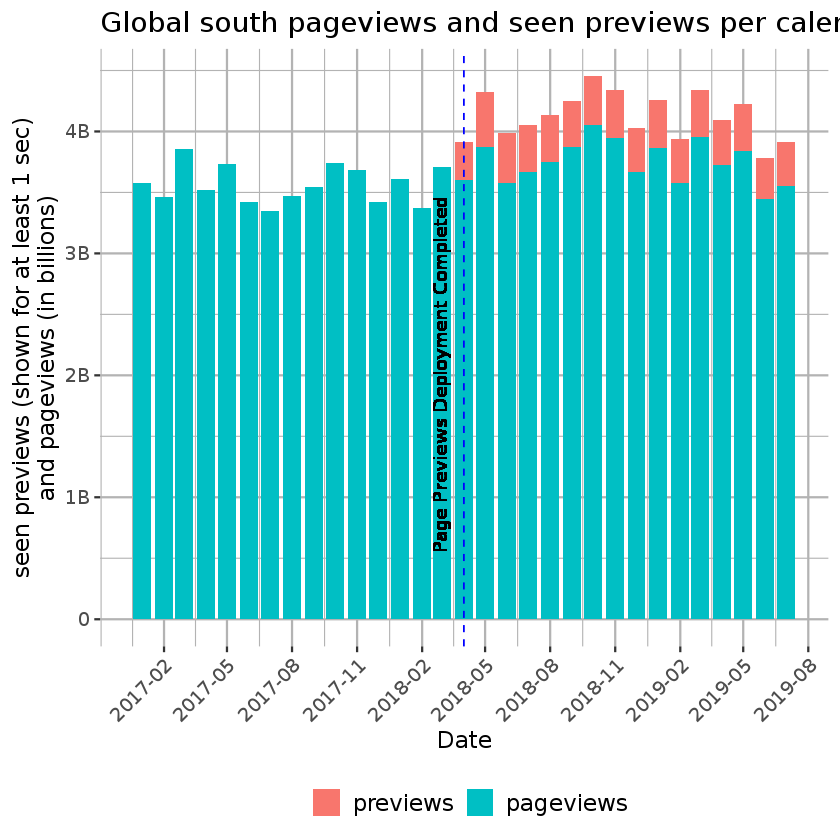

In [42]:
#Stacked bar chart of monthly interactions

p <- ggplot(gs_interactions, aes(x=date, y = monthly_views, fill = forcats::fct_rev(type))) +  
  geom_col() +
  scale_y_continuous("seen previews (shown for at least 1 sec)\nand pageviews (in billions)",  labels = polloi::compress) +
  scale_x_date("Date", labels = date_format("%Y-%m"), date_breaks = "3 months") +
  geom_vline(xintercept = as.numeric(as.Date("2018-04-01")),
             linetype = "dashed", color = "blue") +
  geom_text(aes(x=as.Date('2018-04-01'), y=2E9, label="Page Previews Deployment Completed"), size=4, vjust = -1.2, angle = 90, color = "black") +
  labs(title = "Global south pageviews and seen previews per calendar month") +
  ggthemes::theme_tufte(base_size = 14, base_family = "Gill Sans") +
  theme(axis.text.x=element_text(angle = 45, hjust = 1),
        panel.grid = element_line("gray70"),
        legend.position="bottom",
        legend.title=element_blank(),
        legend.text=element_text(size=14))

ggsave(filename="Global South pageviews and interactions_StackedBar.png", plot = p, path = 'Figures', units = "in", dpi = 192, height = 6, width = 10, limitsize = FALSE)  
p

In [43]:
# Calculate monthly interactions (sum of pageviews and previews) and YoY changes in global south

gs_interactions_total <- gs_interactions %>%
  filter(date >= "2018-04-01") %>% #filter to first month previews rolled out.
  group_by(date) %>%
  summarise(interactions = sum(monthly_views)) %>%
  arrange(date) %>%
  mutate(yoy_percent = (interactions/lag(interactions,12) -1)*100) 

knitr::kable(gs_interactions_total)




|date       | interactions| yoy_percent|
|:----------|------------:|-----------:|
|2018-04-01 |   3911443844|          NA|
|2018-05-01 |   4321566806|          NA|
|2018-06-01 |   3987921459|          NA|
|2018-07-01 |   4056722650|          NA|
|2018-08-01 |   4135632404|          NA|
|2018-09-01 |   4246181686|          NA|
|2018-10-01 |   4454386356|          NA|
|2018-11-01 |   4341707471|          NA|
|2018-12-01 |   4025161324|          NA|
|2019-01-01 |   4253901798|          NA|
|2019-02-01 |   3936263091|          NA|
|2019-03-01 |   4341290576|          NA|
|2019-04-01 |   4091982306|    4.615648|
|2019-05-01 |   4226723078|   -2.194661|
|2019-06-01 |   3785371642|   -5.079082|
|2019-07-01 |   3913795202|   -3.523224|

## Mobile-Heavy Wikis Interactions ##

Pageviews data comes from wmf.pageview_hourly with IE corrections applied. Corrected data is stored in intermediate hive table mneisler.mh_pageviews_corrected with data stored back to September 2016. 

List of corrections and timespans that they are applied to:

* IEPKIRAF: since May 20, 2018
* IE7PKIRAF: January 1-May 19, 2018
* IE7PKIRAF & iOS mainpage: Sept 2016-Dec 31, 2017

### Update mh_pageviews_corrected table ###

In [ ]:
#update pageviews_corrected table with new month data.

mh_pageviews_query <- "

INSERT INTO TABLE mneisler.mh_pageviews_corrected
PARTITION (year, month, day)

SELECT CONCAT(year,'-',LPAD(month,2,'0'),'-',LPAD(day,2,'0')) AS date,
SUM(view_count) AS all_views,
SUM(IF (FIND_IN_SET(project,
'hi.wikipedia,bn.wikipedia,id.wikipedia,ar.wikipedia,mr.wikipedia,fa.wikipedia,sw.wikipedia,tl.wikipedia,zh.wikiquote,th.wikipedia,arz.wikipedia,ml.wikipedia,ta.wikipedia,kn.wikipedia,pt.wiktionary,az.wikipedia,gu.wikipedia,ky.wikipedia,sq.wikipedia,ms.wikipedia'
) > 0, view_count, 0)) AS mh_views,
year, month, day
FROM wmf.pageview_hourly
WHERE (year = '{metrics_year}'AND month = '{metrics_month}')
AND agent_type='user'
AND NOT (country_code IN ('PK', 'IR', 'AF') -- https://phabricator.wikimedia.org/T157404#3194046
AND user_agent_map['browser_family'] = 'IE') -- https://phabricator.wikimedia.org/T193578#4300284
GROUP BY year, month, day
;

In [ ]:
wmf::query_hive(mh_pageviews_query)

### Mobile Heavy Wiki Pageviews ###

In [44]:
## Run pageview query and load data
query <- "
SELECT
date, all_views, mh_views
FROM mneisler.mh_pageviews_corrected
WHERE year >= 2017
"

In [45]:
pageviews_mh <- wmf::query_hive(query)

In [46]:
pageviews_mh $date <- as.Date(pageviews_mh$date, format = "%Y-%m-%d")

In [47]:
#Calculate monthly pageviews and YoY changes on mobile-heavy wikis
mh_pageviews_monthly <- pageviews_mh %>%
  mutate(date = floor_date(date, "month")) %>%
  group_by(date) %>% 
  summarise(monthly_views = sum(as.numeric(mh_views))) %>%
  arrange(date) %>%
  mutate(yoy_percent = (monthly_views/lag(monthly_views,12) -1)*100)  %>%
  mutate(type = "pageviews")

tail(mh_pageviews_monthly)

date,monthly_views,yoy_percent,type
<date>,<dbl>,<dbl>,<chr>
2019-02-01,650360340,14.529972,pageviews
2019-03-01,683682169,13.962936,pageviews
2019-04-01,649681496,15.316568,pageviews
2019-05-01,685429938,18.925811,pageviews
2019-06-01,588140293,7.478616,pageviews
2019-07-01,655773508,11.306399,pageviews


### Mobile Heavy Wiki Previews ###

In [29]:
# Collect previews from wmf.virtualpageview_hourly. Page previews was completed in April 2018.

mh_previews_query <- "
SELECT CONCAT(year,'-',LPAD(month,2,'0'),'-',LPAD(day,2,'0')) AS date,
  SUM(view_count) AS all_views,
SUM(IF (FIND_IN_SET(project,
'hi.wikipedia,bn.wikipedia,id.wikipedia,ar.wikipedia,mr.wikipedia,fa.wikipedia,sw.wikipedia,tl.wikipedia,zh.wikiquote,th.wikipedia,arz.wikipedia,ml.wikipedia,ta.wikipedia,kn.wikipedia,pt.wiktionary,az.wikipedia,gu.wikipedia,ky.wikipedia,sq.wikipedia,ms.wikipedia'
) > 0, view_count, 0)) AS mh_views
  FROM wmf.virtualpageview_hourly 
  WHERE (year = 2018 AND month >=4) OR (year = 2019)
  GROUP BY year, month, day
"

In [30]:
previews_mh <- wmf::query_hive(mh_previews_query)

In [31]:
previews_mh$date <- as.Date(previews_mh$date, format = "%Y-%m-%d")

In [32]:
#Calculate monthly previews and YoY changes on mobile-heavy wikis
mh_previews_monthly <- previews_mh %>%
    mutate(date = floor_date(date, "month")) %>%
    group_by(date) %>% 
    summarise(monthly_views = sum(as.numeric(mh_views))) %>%
    arrange(date) %>%
   mutate(yoy_percent = (monthly_views/lag(monthly_views,12) -1)*100) %>%
    mutate(type = "previews")

tail(mh_previews_monthly)

date,monthly_views,yoy_percent,type
<date>,<dbl>,<dbl>,<chr>
2019-02-01,33318281,NA,previews
2019-03-01,33671261,NA,previews
2019-04-01,33236300,-3.2241928,previews
2019-05-01,33743376,-4.8786373,previews
2019-06-01,29193310,-5.5651072,previews
2019-07-01,31768798,0.5031548,previews


### Monthly Interactions on Mobile-Heavy Wikis (Pageviews + Seen Previews) ###

In [48]:
 mh_interactions <- rbind(mh_pageviews_monthly, mh_previews_monthly) 

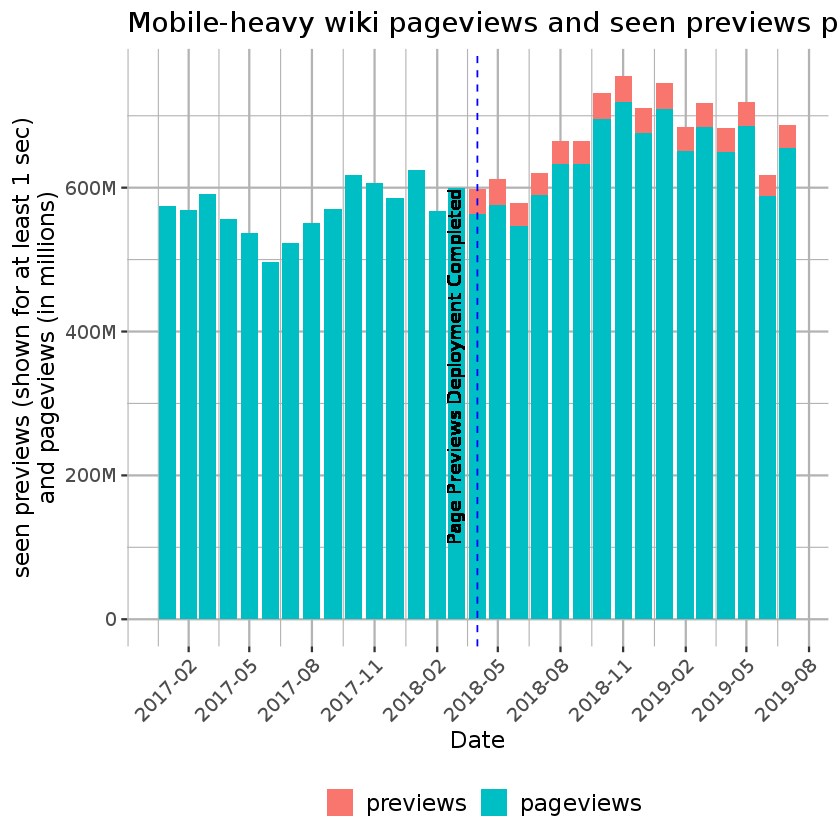

In [49]:
#Create chart of interactions broken down by pageviews and previews
 p <- ggplot(mh_interactions, aes(x=date, y = monthly_views, fill = forcats::fct_rev(type))) +  
    geom_col() +
    scale_y_continuous("seen previews (shown for at least 1 sec)\nand pageviews (in millions)",labels = polloi::compress) +
    scale_x_date("Date", labels = date_format("%Y-%m"), date_breaks = "3 months") +
    geom_vline(xintercept = as.numeric(as.Date("2018-04-01")),
               linetype = "dashed", color = "blue") +
    geom_text(aes(x=as.Date('2018-04-01'), y=350E6, label="Page Previews Deployment Completed"), size=4, vjust = -1.2, angle = 90, color = "black") +
    labs(title = "Mobile-heavy wiki pageviews and seen previews per calendar month") +
    ggthemes::theme_tufte(base_size = 14, base_family = "Gill Sans") +
    theme(axis.text.x=element_text(angle = 45, hjust = 1),
          panel.grid = element_line("gray70"),
          legend.position="bottom",
          legend.title=element_blank(),
          legend.text=element_text(size=14))
  
  ggsave(filename="Mobile heavy wiki interactions_StackedBar.png", plot = p, path = 'Figures', units = "in", dpi = 192, height = 6, width = 10, limitsize = FALSE)  
p

In [50]:
# Calculate monthly interactions (sum of pageviews and previews) on desktop
 
mh_interactions_total <- mh_interactions %>%
    filter(date >= '2018-04-01') %>%#page previews rolled out in April 2018
    group_by(date) %>%
    summarise(interactions = sum(monthly_views)) %>%
    arrange(date) %>%
    mutate(yoy_percent = (interactions/lag(interactions,12) -1)*100) 

knitr::kable(mh_interactions_total)



|date       | interactions| yoy_percent|
|:----------|------------:|-----------:|
|2018-04-01 |    597733155|          NA|
|2018-05-01 |    611824887|          NA|
|2018-06-01 |    578129792|          NA|
|2018-07-01 |    620770406|          NA|
|2018-08-01 |    664662963|          NA|
|2018-09-01 |    664910217|          NA|
|2018-10-01 |    731810071|          NA|
|2018-11-01 |    755204361|          NA|
|2018-12-01 |    711396621|          NA|
|2019-01-01 |    745954108|          NA|
|2019-02-01 |    683678621|          NA|
|2019-03-01 |    717353430|          NA|
|2019-04-01 |    682917796|   14.251283|
|2019-05-01 |    719173314|   17.545613|
|2019-06-01 |    617333603|    6.781143|
|2019-07-01 |    687542306|   10.756296|